In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-task/movies_overview.csv
/kaggle/input/nlp-task/movies_genres.csv


In [2]:
movies_df = pd.read_csv("/kaggle/input/nlp-task/movies_overview.csv")

genres_df = pd.read_csv("/kaggle/input/nlp-task/movies_genres.csv")

In [3]:
print("🎬 Movie Dataset:")
display(movies_df.head())

print("\n🎭 Genre Reference Table:")
display(genres_df.head())

🎬 Movie Dataset:


,title,overview,genre_ids
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]"
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[18, 80]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18]



🎭 Genre Reference Table:


,id,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime


In [4]:
print("Info of Movies:")
movies_df.info()

print("\n Info of Genres: ")
genres_df.info()

Info of Movies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      9980 non-null   object
 1   overview   9980 non-null   object
 2   genre_ids  9980 non-null   object
dtypes: object(3)
memory usage: 234.0+ KB

 Info of Genres: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19 non-null     int64 
 1   name    19 non-null     object
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes


In [5]:
movies_df.duplicated().sum()

genres_df.duplicated().sum()

0

In [6]:
genre_map = dict(zip(genres_df['id'], genres_df['name']))

def map_genres(genre_id_list):
    return[genre_map.get(gid, 'Unknown') for gid in eval(genre_id_list)]

movies_df['genre_names'] = movies_df['genre_ids'].apply(map_genres)

movies_df[['title', 'genre_ids', 'genre_names']].head()

,title,genre_ids,genre_names
0,The Shawshank Redemption,"[18, 80]","[Drama, Crime]"
1,The Godfather,"[18, 80]","[Drama, Crime]"
2,The Godfather Part II,"[18, 80]","[Drama, Crime]"
3,Schindler's List,"[18, 36, 10752]","[Drama, History, War]"
4,12 Angry Men,[18],[Drama]


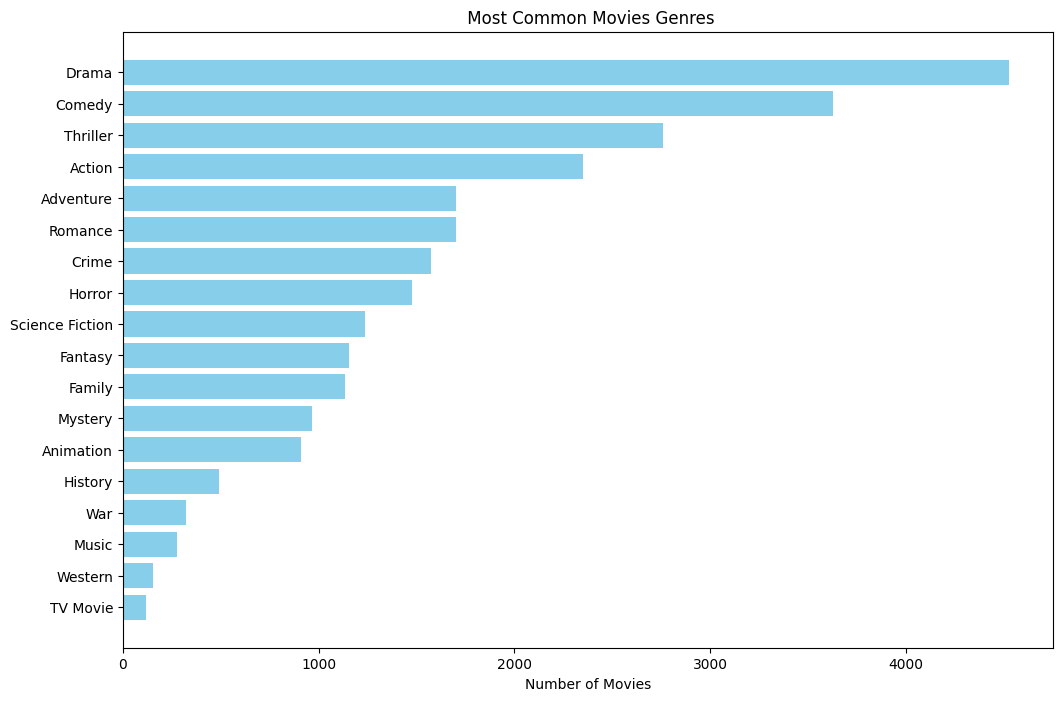

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

all_genres = [genre for sublist in movies_df['genre_names'] for genre in sublist]

genre_counts = Counter(all_genres)

genre_freq_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(12,8))
plt.barh(genre_freq_df['Genre'], genre_freq_df['Count'], color='skyblue')
plt.gca().invert_yaxis()
plt.title(" Most Common Movies Genres")
plt.xlabel("Number of Movies")
plt.show()

In [8]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return "".join(words)

movies_df['clean_overview'] = movies_df['overview'].apply(clean_text)

movies_df[['title', 'overview', 'clean_overview']].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,overview,clean_overview
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,imprisoned1940sdoublemurderwifeloverupstanding...
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",spanningyears19451955chroniclefictionalitalian...
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,continuingsagacorleonecrimefamilyyoungvitocorl...
3,Schindler's List,The true story of how businessman Oskar Schind...,truestorybusinessmanoskarschindlersavedthousan...
4,12 Angry Men,The defense and the prosecution have rested an...,defenseprosecutionrestedjuryfilingjuryroomdeci...


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(movies_df['genre_names'])
genre_classes = mlb.classes_


print(f'y shape: {y.shape}')
print(f'Genres: {genre_classes}')


y shape: (9980, 18)
Genres: ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Drama' 'Family'
 'Fantasy' 'History' 'Horror' 'Music' 'Mystery' 'Romance'
 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western']


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))


X = tfidf.fit_transform(movies_df['clean_overview'])

print(f"X shape (TF-IDF): {X.shape}")


X shape (TF-IDF): (9980, 5000)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = OneVsRestClassifier(LogisticRegression(max_iter=200))


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print("📊 Classification Report (per genre):")
print(classification_report(y_test, y_pred, target_names=genre_classes))


📊 Classification Report (per genre):
                 precision    recall  f1-score   support

         Action       0.00      0.00      0.00       476
      Adventure       0.00      0.00      0.00       326
      Animation       0.00      0.00      0.00       191
         Comedy       0.00      0.00      0.00       721
          Crime       0.00      0.00      0.00       333
          Drama       1.00      0.00      0.00       905
         Family       0.00      0.00      0.00       233
        Fantasy       0.00      0.00      0.00       228
        History       0.00      0.00      0.00        86
         Horror       0.00      0.00      0.00       297
          Music       0.00      0.00      0.00        55
        Mystery       0.00      0.00      0.00       200
        Romance       0.00      0.00      0.00       360
Science Fiction       0.00      0.00      0.00       248
       TV Movie       0.00      0.00      0.00        29
       Thriller       0.00      0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
model0 = OneVsRestClassifier(LogisticRegression(max_iter=300, class_weight='balanced'))


In [13]:
from sklearn.ensemble import RandomForestClassifier
model1 = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, class_weight='balanced'))


In [14]:
from sklearn.naive_bayes import MultinomialNB
model2 = OneVsRestClassifier(MultinomialNB())


In [15]:
from sklearn.metrics import hamming_loss, f1_score

print("🔎 Hamming Loss:", hamming_loss(y_test, y_pred))
print("🎯 Micro F1 Score:", f1_score(y_test, y_pred, average='micro'))


🔎 Hamming Loss: 0.14851926074370964
🎯 Micro F1 Score: 0.0003746721618583739


In [16]:
# Train all models first
model0.fit(X_train, y_train)   # Logistic Regression
model1.fit(X_train, y_train)   # Random Forest
model2.fit(X_train, y_train)   # Naive Bayes

# Predict and evaluate each model
from sklearn.metrics import classification_report

print("📘 Logistic Regression Results:")
y_pred_logreg = model0.predict(X_test)
print(classification_report(y_test, y_pred_logreg, target_names=genre_classes))

print("🌲 Random Forest Results:")
y_pred_rf = model1.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=genre_classes))

print("🧠 Naive Bayes Results:")
y_pred_nb = model2.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=genre_classes))


📘 Logistic Regression Results:
                 precision    recall  f1-score   support

         Action       0.00      0.00      0.00       476
      Adventure       0.00      0.00      0.00       326
      Animation       0.00      0.00      0.00       191
         Comedy       0.00      0.00      0.00       721
          Crime       1.00      0.00      0.01       333
          Drama       1.00      0.00      0.00       905
         Family       0.00      0.00      0.00       233
        Fantasy       0.00      0.00      0.00       228
        History       0.00      0.00      0.00        86
         Horror       0.00      0.00      0.00       297
          Music       0.00      0.00      0.00        55
        Mystery       0.00      0.00      0.00       200
        Romance       1.00      0.01      0.01       360
Science Fiction       0.00      0.00      0.00       248
       TV Movie       0.00      0.00      0.00        29
       Thriller       0.00      0.00      0.00       563

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

         Action       0.24      1.00      0.39       476
      Adventure       0.16      1.00      0.28       326
      Animation       0.00      0.00      0.00       191
         Comedy       0.00      0.00      0.00       721
          Crime       0.17      1.00      0.29       333
          Drama       1.00      0.00      0.00       905
         Family       0.00      0.00      0.00       233
        Fantasy       0.00      0.00      0.00       228
        History       0.04      1.00      0.08        86
         Horror       0.15      1.00      0.26       297
          Music       0.00      0.00      0.00        55
        Mystery       0.00      0.00      0.00       200
        Romance       1.00      0.01      0.01       360
Science Fiction       0.00      0.00      0.00       248
       TV Movie       0.00      0.00      0.00        29
       Thriller       0.28      1.00      0.44       563
            War       0.03    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


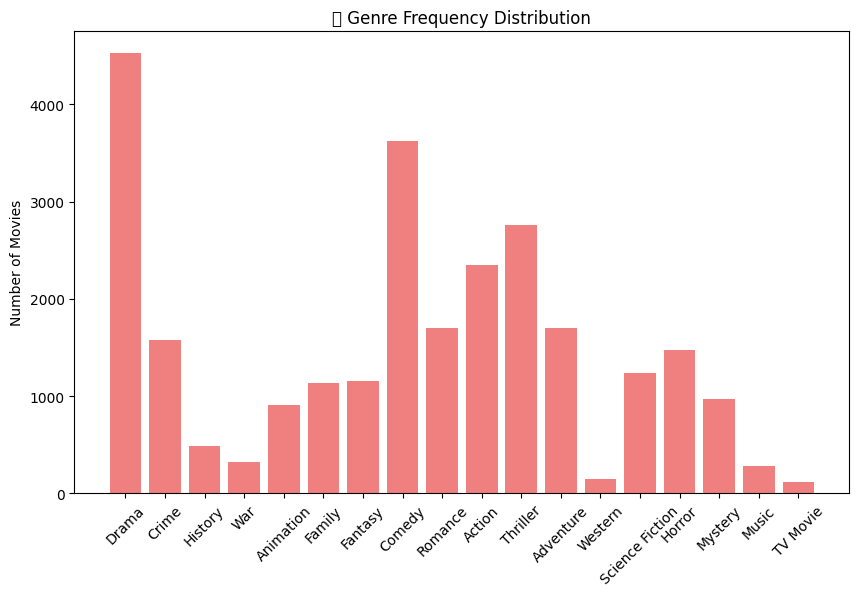

In [17]:

# Count individual label frequencies
all_labels = [g for sublist in movies_df['genre_names'] for g in sublist]
genre_freq = Counter(all_labels)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(genre_freq.keys(), genre_freq.values(), color="lightcoral")
plt.title("🎭 Genre Frequency Distribution")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()


In [18]:

y_probs = model1.predict_proba(X_test)


threshold = 0.3  # Lower threshold to include more genres
y_pred_thresh = (y_probs >= threshold).astype(int)


from sklearn.metrics import classification_report, hamming_loss, f1_score

print("🔧 Thresholded Predictions @ 0.3:")
print(classification_report(y_test, y_pred_thresh, target_names=genre_classes))
print("🔍 Hamming Loss:", hamming_loss(y_test, y_pred_thresh))
print("🎯 Micro F1 Score:", f1_score(y_test, y_pred_thresh, average='micro'))


🔧 Thresholded Predictions @ 0.3:
                 precision    recall  f1-score   support

         Action       0.24      1.00      0.39       476
      Adventure       0.16      1.00      0.28       326
      Animation       0.10      1.00      0.17       191
         Comedy       0.36      1.00      0.53       721
          Crime       0.17      1.00      0.29       333
          Drama       0.45      1.00      0.62       905
         Family       0.12      1.00      0.21       233
        Fantasy       0.11      1.00      0.21       228
        History       0.04      1.00      0.08        86
         Horror       0.15      1.00      0.26       297
          Music       0.03      1.00      0.05        55
        Mystery       0.10      1.00      0.18       200
        Romance       0.18      1.00      0.31       360
Science Fiction       0.12      1.00      0.22       248
       TV Movie       0.01      1.00      0.03        29
       Thriller       0.28      1.00      0.44       5

In [19]:
import joblib

joblib.dump(model1, "genre_classifier.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(mlb, "label_binarizer.pkl")


['label_binarizer.pkl']